# Installation

In [1]:
# pip install datasets trl transformers accelerate matplotlib ipywidgets bitsandbytes

# Parameter Stup

In [1]:
DATASET = "FoCus"                                       # "FoCus" 

_COT = ""                                               #  "",    "-COT"

SCORING_METHOD = "perso"                         # "simple", "perso"

LLMS = [
    ("Qwen2-5B-Instruct", "Qwen/Qwen2-0.5B-Instruct"),
    ("Mistral-7B-Instruct", "mistralai/Mistral-7B-Instruct-v0.2"),
]

LLM = LLMS[0]

DPO_PATH = f"{LLM[0]}-{DATASET}-{SCORING_METHOD}-DPO"

In [2]:
DPO_PATH

'Qwen2-5B-Instruct-FoCus-perso-DPO'

# Dataset Preparation

In [4]:
from datasets import Dataset
import pandas as pd

print( f"Loading {DATASET} dataset with {SCORING_METHOD} scoring method and {_COT} COT")

  
df = pd.read_csv(f"dpo_datasets/FoCus_{SCORING_METHOD}_dpo{_COT}.csv")


train_dataset = Dataset.from_pandas(df)

df.head(3)

Loading FoCus dataset with perso scoring method and  COT


,prompt,chosen,rejected,score_chosen,score_rejected
0,I will provide you with a conversation context...,"{""response"": ""The South Foreland Lighthouse is...","{""response"": ""I would love to visit the South ...",0.695,0.575
1,I will provide you with a conversation context...,"{""response"": ""The South Foreland Lighthouse is...","{""response"": ""The South Foreland Lighthouse, b...",0.695,0.294
2,I will provide you with a conversation context...,"{""response"": ""As a fellow lighthouse enthusias...","{""response"": ""I would love to visit the South ...",0.756,0.575


In [5]:
print(train_dataset[600])  

{'prompt': 'I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\nAs a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\nParticipant Personas:\nI have never been to Buckinghamshire.I am from England.I have finished school.I live in a House.I do not have a garden.\n\nConversation Context:\nUser1: Cool! And what is it?\nUser2: It is a grade I listed country house, a kind of place you live in.\nUser1: Awesome! And where is it?\nUser2: It is in Stowe, Buckinghamshire, England, the country you are from.\nUser1: Nice! And is it still used?\nUser2: It is now the home of Stowe School, an independent school.\nUser1: Awesome! Is it a well preserved place?\nUser2: Yes, the owners of the house, the Stowe House Preservation Trust, as of March 2013, had spent more than £25m on the restoration of the house.\nUser1: Incredible! Is it op

In [6]:
print(train_dataset.column_names)
print(len(train_dataset))
train_dataset.shape

['prompt', 'chosen', 'rejected', 'score_chosen', 'score_rejected']
9184


(9184, 5)

# DPO Trainer

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import DPOConfig, DPOTrainer
import torch

## Simple DPO

In [7]:
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2-0.5B-Instruct", torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")

training_args = DPOConfig(
    per_device_train_batch_size=4,  # or 2
    gradient_accumulation_steps=4,  # to simulate larger batch size
    output_dir= DPO_PATH,
    logging_steps=200,
)

trainer = DPOTrainer(model = model, args = training_args, processing_class = tokenizer, train_dataset= train_dataset)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Extracting prompt in train dataset:   0%|          | 0/9024 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/9024 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9024 [00:00<?, ? examples/s]

In [8]:
trainer.train()

Step,Training Loss
200,0.063700
400,0.015600
600,0.007200
800,0.002600
1000,0.000400
1200,0.002700
1400,0.000100
1600,0.000000


TrainOutput(global_step=1692, training_loss=0.010912232092225563, metrics={'train_runtime': 7479.4161, 'train_samples_per_second': 3.62, 'train_steps_per_second': 0.226, 'total_flos': 0.0, 'train_loss': 0.010912232092225563, 'epoch': 3.0})

## Perso DPO

In [7]:
from trl import DPOTrainer
import torch
import torch.nn.functional as F

class ScoreWeightedDPOTrainer(DPOTrainer):
    def _compute_loss(self, model, inputs, return_outputs=False):
        # Extract input fields
        chosen_input_ids = inputs["chosen_input_ids"]
        rejected_input_ids = inputs["rejected_input_ids"]
        attention_mask = inputs.get("attention_mask", None)
        scores_chosen = inputs["score_chosen"]
        scores_rejected = inputs["score_rejected"]

        # Use built-in DPO loss logic
        loss_dict = self.dpo_loss(
            model=model,
            chosen_input_ids=chosen_input_ids,
            rejected_input_ids=rejected_input_ids,
            attention_mask=attention_mask,
        )

        base_loss = loss_dict["loss"]  # shape: [batch_size]

        # Compute margin and apply score-based weighting
        margin = scores_chosen - scores_rejected  # shape: [batch_size]
        weight = torch.sigmoid(margin)  # soft normalization to (0, 1)
        weighted_loss = (weight * base_loss).mean()

        return (weighted_loss, None) if return_outputs else weighted_loss

In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2-0.5B-Instruct", torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")

# model = AutoModelForCausalLM.from_pretrained(LLM[1],  load_in_8bit=True, device_map='cuda', torch_dtype=torch.float32)
# tokenizer = AutoTokenizer.from_pretrained(LLM[1])


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [9]:
# DPO training configuration
training_args = DPOConfig(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    output_dir= DPO_PATH,
    logging_steps=100,
    warmup_steps=150,
)

# Initialize custom trainer
trainer = ScoreWeightedDPOTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    processing_class=tokenizer
)

Extracting prompt in train dataset:   0%|          | 0/9184 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/9184 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9184 [00:00<?, ? examples/s]

In [10]:
trainer.train()

Step,Training Loss
100,0.315200
200,0.066600
300,0.041900
400,0.030400
500,0.030600
600,0.019600
700,0.008100
800,0.004600
900,0.004300
1000,0.004300


TrainOutput(global_step=1722, training_loss=0.030764611435753406, metrics={'train_runtime': 7457.7204, 'train_samples_per_second': 3.694, 'train_steps_per_second': 0.231, 'total_flos': 0.0, 'train_loss': 0.030764611435753406, 'epoch': 3.0})

# Plots

In [15]:
import json
import matplotlib.pyplot as plt

# Load logs
with open(f"{DPO_PATH}/checkpoint-1731/trainer_state.json") as f:
    state = json.load(f)
log_history = state["log_history"]


# Extract steps and metrics
steps = [entry["step"] for entry in log_history if "loss" in entry]
losses = [entry["loss"] for entry in log_history if "loss" in entry]
grad_norms = [entry["grad_norm"] for entry in log_history if "grad_norm" in entry]
reward_margins = [entry["rewards/margins"] for entry in log_history if "rewards/margins" in entry]
accuracies = [entry["rewards/accuracies"] for entry in log_history if "rewards/accuracies" in entry]


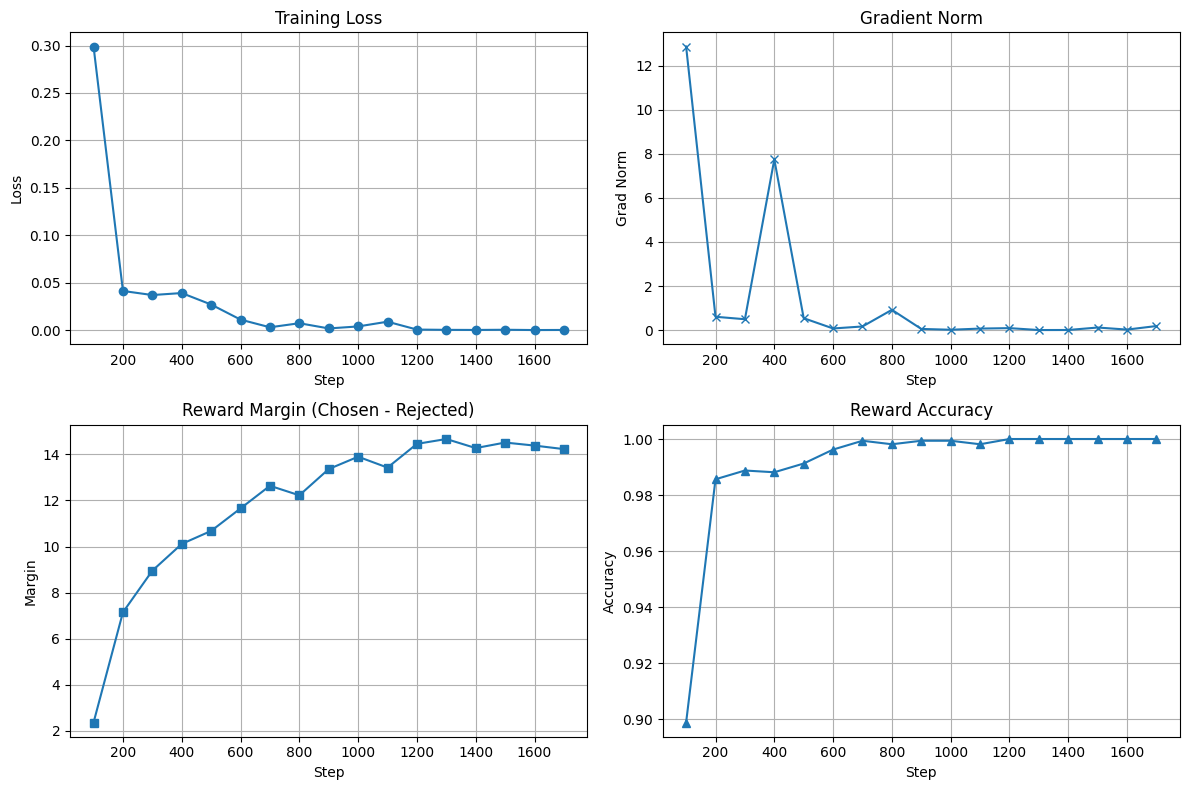

In [16]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(steps, losses, marker='o')
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Step")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True)

axs[0, 1].plot(steps, grad_norms, marker='x')
axs[0, 1].set_title("Gradient Norm")
axs[0, 1].set_xlabel("Step")
axs[0, 1].set_ylabel("Grad Norm")
axs[0, 1].grid(True)

axs[1, 0].plot(steps, reward_margins, marker='s')
axs[1, 0].set_title("Reward Margin (Chosen - Rejected)")
axs[1, 0].set_xlabel("Step")
axs[1, 0].set_ylabel("Margin")
axs[1, 0].grid(True)

axs[1, 1].plot(steps, accuracies, marker='^')
axs[1, 1].set_title("Reward Accuracy")
axs[1, 1].set_xlabel("Step")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig(f"plots/{DPO_PATH}-training-metrics.pdf", format="pdf")
plt.show()
plt.close()


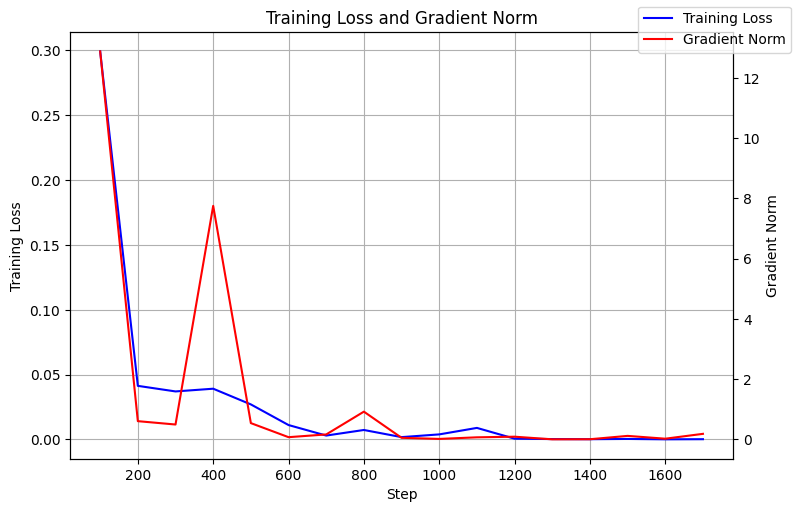

In [17]:
# -------------------
# Plot 1: Loss & Grad Norm
# -------------------

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("Step")
ax1.set_ylabel("Training Loss")
l1, = ax1.plot(steps, losses, color='blue', label="Training Loss")
ax1.tick_params(axis='y')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Gradient Norm")
l2, = ax2.plot(steps, grad_norms, color='red', label="Gradient Norm")
ax2.tick_params(axis='y')

# Combine both line objects into one legend
lines = [l1, l2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.title("Training Loss and Gradient Norm")
plt.savefig(f"plots/{DPO_PATH}-loss-gradnorm.pdf", format="pdf")
plt.show()
plt.close()


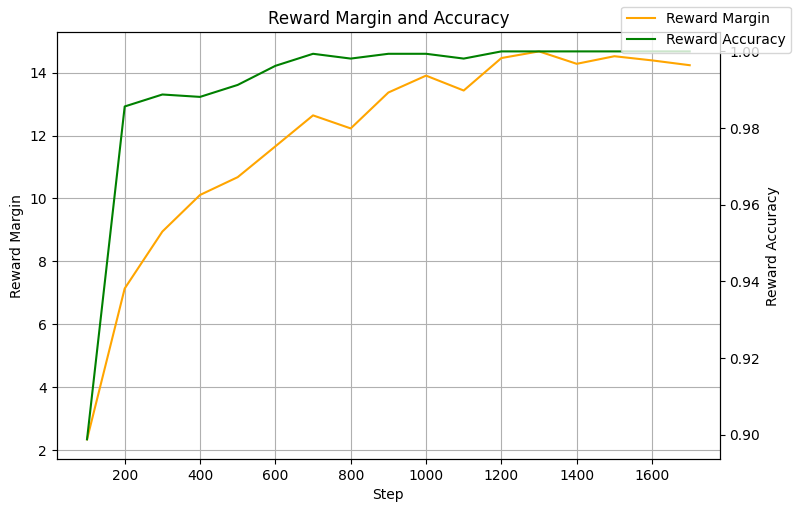

In [18]:
# -------------------
# Plot 2: Reward Margin & Accuracy
# -------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("Step")
ax1.set_ylabel("Reward Margin")
l1, = ax1.plot(steps, reward_margins, color='orange', label="Reward Margin")
ax1.tick_params(axis='y')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Reward Accuracy")
l2, = ax2.plot(steps, accuracies, color='green', label="Reward Accuracy")
ax2.tick_params(axis='y')

# Combine both line objects into one legend 
lines = [l1, l2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.title("Reward Margin and Accuracy")
plt.savefig(f"plots/{DPO_PATH}-margin-accuracy.pdf", format="pdf")
plt.show()
plt.close()


# Response Generation

In [3]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
DATASET = "FoCus"   
SET = "valid"
 
_COT = ""                                       # "",   "-COT"        
COT_SETUP = True if _COT == "-COT" else False

In [5]:
import pandas as pd
import warnings
import logging
import torch
import torch

torch.cuda.empty_cache()

warnings.filterwarnings("ignore")
logging.getLogger('transformers').setLevel(logging.ERROR)


# Loading the prompt
df = pd.read_csv(f'./Prompts/{DATASET}-{SET}.csv')

df.head(10)

,personas,context,act_response
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,User2: The history of the house you are intere...
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",User2: This house was use as a stop for slaves...
2,I am fascinated by the Spanish Colonial Reviva...,"User1: Wow, this is amazing! What is this?\nUs...","User2: Sure, you will like to know that this p..."
3,I want to become a college student.I want to s...,User1: Where is this place?\nUser2: Hello! Wel...,User2: Technische Universität Darmstadt in the...
4,I like to visit england.I love church.I would ...,User1: Where is this place?\nUser2: This place...,"User2: I suggest a place, for your wish of see..."
5,I would like to go to University.I live in Mic...,User1: I think Ive been there before but I don...,User2: They offer 132 bachelors degree program...
6,I love nice hotels.I would like to go to Calif...,User1: I think Ive been there before but I don...,User2: Its current owner is Anbang Insurance G...
7,I have the fantasy about valley.I like lakes.I...,"User1: I know this place, but I dont remember ...",User2: You can view Hat Creek valley and the T...
8,I am willing to start a seminary in New Brunsw...,User1: I think Ive been there before but I don...,User2: It was closely connected with Rutgers U...
9,I like the National War Memorial.I hope to mov...,"User1: I know this place, but I dont remember ...",User2: You have interest in history and will l...


In [6]:
# Function to generate a prompt
def create_prompt(personas, context, include_cot=False):

    prompt = (
        "I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\n"
        "As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\n"
        "Participant Personas:\n"
        f"{personas}\n\n"
        "Conversation Context:\n"
        f"{context}\n\n"
        "Task Instruction:\n"
        "* Provide an unannotated response.\n"
        "* If only one persona is available, personalize the response accordingly.\n"
        "* If the conversation context is a single query, respond appropriately to the query.\n"
    )
    
    if include_cot:
        prompt += (
            "* Apply Chain of Thought reasoning to reflect on the alignment of your response with the personas.\n"
        )

    prompt += (
        "\nOutput Format: only give a JSON of the following format:\n"
        "{\n"
    )
    
    if include_cot:
        prompt += (
            '  "reasoning": "briefly describe your personalization process (in 110 words or less)."\n'
        )
        
    prompt += (
        '  "response": "provide the personalized natural language response here (in 110 words or less)."\n'
        "}\n"
    )

    return prompt

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

####### Benchmark ########
# LLM = "Qwen2-7B-Benchmark"

# model = AutoModelForCausalLM.from_pretrained("LLMs/Qwen2-7B-Instruct", trust_remote_code=True)
# tokenizer = AutoTokenizer.from_pretrained("Tokenizers/Qwen2-7B-Instruct", trust_remote_code=True)


########  DPO   ########

LLM = f"Qwen2-5B-Instruct-{SCORING_METHOD}"
checkpoint_path = f"{DPO_PATH}/checkpoint-1722"

model = AutoModelForCausalLM.from_pretrained(checkpoint_path, torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

############################


MAX_NEW_TOKEN = 220 if COT_SETUP else 110

generation_params = {
    
    "max_new_tokens": MAX_NEW_TOKEN,      # Based on max response length + reasoning
    "temperature": 0,                     # Based on FELM paper (Greedy Setup)
    "do_sample": False
}

In [8]:
first_row = df.iloc[29]
personas = first_row['personas']
context = first_row['context']

# Example usage
prompt = create_prompt(personas, context, include_cot=COT_SETUP)
print(prompt)

I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.
As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.

Participant Personas:
I like construction.I like historic places.I like things in the army.I like architecture.I would like to visit San Angelo, Texas.

Conversation Context:
User1: I know this place, but I dont remember the name of this place.
User2: This is Fort Concho, a former US Army facility and a national historic district. As you like historical places and things in the army I thought you would be interested in this place.
User1: Where is?
User2: It is in San Angelo, Texas. As you said you would like to visit San Angelo, Texas I looked for a place that might interest you.
User1: Is there anything that might interest me?
User2: The building was completed in February 1879 as a school and chapel, it was the last

In [9]:
from transformers import pipeline

# Initialize the text generation pipeline
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=device)

# Generate a response
output = generator(prompt, **generation_params)
response = output[0]['generated_text'][len(prompt):]

# Print the response
print(response)

}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}
}



In [10]:
import time
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Iterate through the DataFrame and generate responses
gen_responses = []
response_times = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating responses"):
    personas = row['personas']
    context = row['context']
    
    # Create the prompt
    prompt = create_prompt(personas, context, COT_SETUP)
    
    # Measure the start time
    start_time = time.time()
    
    # Generate a response
    output = generator(prompt, **generation_params)[0]['generated_text']
    
    # Measure the end time and calculate the duration
    end_time = time.time()
    response_time = end_time - start_time
    
    response = output[len(prompt):]

    # Store the generated response and response time
    gen_responses.append(response)
    response_times.append(response_time)

# Create a DataFrame with the responses and response times
response_df = pd.DataFrame({
    'gen_response': gen_responses,
    'response_time': response_times
})


## Save the response DataFrame to a CSV and Excel file
response_df.to_csv(f'./Raw Responses/{DATASET}/{LLM}{_COT}.csv', index = False)

Generating responses: 100%|██████████| 1000/1000 [14:36<00:00,  1.14it/s]


In [11]:
response_df.head(20)

,gen_response,response_time
0,"""}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n...",0.899485
1,"""}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n...",0.866751
2,}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}...,0.878549
3,"""}\n}\n}\n}\n\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}...",0.886416
4,"""}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n...",0.873151
5,"""}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n...",0.875181
6,"""}\n}\n\nOr\n\n{\n ""response"": ""Hello! It's g...",0.878285
7,"""}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n...",0.884726
8,"""}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n...",0.869357
9,"""}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n}\n...",0.870828
